# Makemore Part2
Try the same problem but with the neural network approach <br>

##### **Result:** Much more name like than bigram (like kyla, halisa).
##### **Further improvment** from the original code (Details at the bottom-half) validation loss improved by 1.8% (2.2 -> 2.16)
##### **recreation of the paper:** https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
##### **Andrej Karpathy video:** https://youtu.be/TCH_1BHY58I?si=tn8Bn6z6n93YaPHY

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [42]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [43]:
len(words)

32033

In [44]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [45]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


# We divide the dataset into => training set, test set and validation set
Xtr, Ytr = build_dataset(words[:n1])            
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [46]:
X, Y =build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [47]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [48]:
C = torch.rand((27,2))              # tuples of numbers that represents each characters.
                                    # 2 numbers represent each character.

In [49]:
C[5]                # indexing is faster 

tensor([0.5921, 0.9868])

In [50]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C

tensor([0.5921, 0.9868])

In [51]:
emb = C[X] 
emb.shape

torch.Size([228146, 3, 2])

In [52]:
W1 = torch.randn((6,100))               # 100 neurons
b1 = torch.rand(100)

In [53]:
# We wanted to multiply matrix emb with W1
# but the dimesions is not quite right [32,3,2] @ [6,100] is not possible 
# we have to concat the last two dimensions together

# There are many solutions

In [54]:
# 1
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([228146, 6])

In [55]:
# 2
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([228146, 6])

In [56]:
# 3 This is the best one
h = torch.tanh(emb.view(-1,6) @ W1 + b1)        # .view is more efficient way to do it since it does't create any new memory

In [57]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [58]:
logits = h @ W2 + b2                            # "logits" refer to the raw, unnormalized scores output by a model 
                                                # before they are transformed into probabilities.

                                                # In neural networks, logits normally are the output of final layers
                                                # In this case we are doing only 2 layers of nn. Therefore, w2 and b2 produce the logits

In [59]:
logits.shape 

torch.Size([228146, 27])

In [60]:
counts = logits.exp()
prob = counts / counts.sum(1,keepdim=True)              # This is also called Softmax

In [61]:
prob.shape

torch.Size([228146, 27])

In [62]:
# loss = -prob[torch.arange(32),Y].log().mean()
# loss

In [63]:
# ------------ now made respectable :) ---------------

In [64]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

### improved version

In [65]:
# This is the modified code 
# I added addtional layer and increase the number of neurons in each layer
# to make the model more powerful.


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 200), generator=g)       # add addtional layer
b2 = torch.randn(200, generator=g)


W3 = torch.randn((200, 27), generator=g)
b3 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2,W3,b3]


# The original code
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C = torch.randn((27, 10), generator=g)
# W1 = torch.randn((30, 200), generator=g)
# b1 = torch.randn(200, generator=g)
# W2 = torch.randn((200, 27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]

In [66]:
sum(p.nelement() for p in parameters) # number of parameters in total

                                      # The number of parameters before modified is 11897

58367

In [67]:
emb = C[X]
h = torch.tanh(emb.view(-1,60) @  W1 + b1) # (32,100)
j = torch.tanh(h @ W2 + b2)
logits = j @ W3 + b3 # (32,27)

# counts = logits.exp()
# prob = counts / counts.sum(1,keepdim=True)
# loss = -prob[torch.arange(32),Y].log().mean()

loss = F.cross_entropy(logits,Y)                # F.cross_entropy has much more benefits
                                                # it doesn't create intermediate tensors 
                                                # cluster up all these tensor
                                                # much more!

                                                # also our original code will not work when some of the logits are very big.
                                                # numerically well behave
loss

tensor(28.3461)

In [68]:
for p in parameters:
    p.requires_grad = True

In [69]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [70]:
lri = []
lossi = []
stepi = []

In [71]:
torch.randint(0,Xtr.shape[0],(64,))

tensor([131539,  97385,  85814,  98710,  73320,   9932,  39228, 133425, 135532,
        122964,  66607, 179802, 125711, 142207, 118712,  39925, 124293,  17900,
          5122, 114291, 103992,  87946,  65199, 138883,  78845,  71124,  20953,
        106115, 168144, 147044, 167195, 152663,  28596, 182258,  15979,  35317,
         73713,  14413, 114069,  45830,  83350, 165265,  73047,  21867, 180714,
         54443, 105705, 121748,  57710, 102807, 120899, 131129, 173782, 118339,
         64889,  80774, 125018,  36575,   3537,  52583, 159845, 161565, 137678,
         40820])

In [72]:

for i in range(200000):

    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0] , (32,))       # it is much faster even it is not the actual gradient



    #forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.sigmoid(emb.view(-1,60)@ W1 + b1) # (32,100)
    j = torch.sigmoid(h @ W2 + b2)
    logits = j @ W3 + b3
    loss = F.cross_entropy(logits,Ytr[ix])
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    #update the parameter
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        if i >= 30000:
            lr = 0.01
        p.data += -lr * p.grad                # first the learning rate is 0.1 but now it is 0.01 after we trained it for 20000 times
                                              # learning rate decay


    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())              

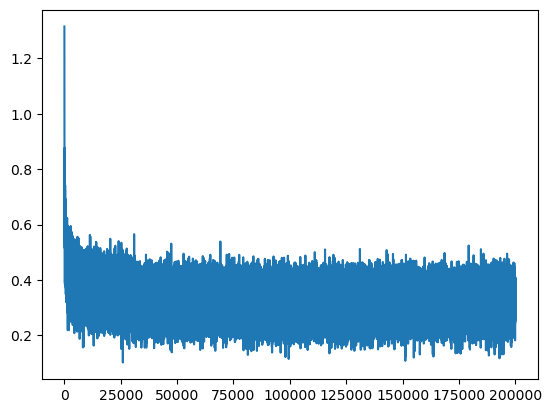

In [73]:
plt.plot(stepi,lossi)

In [74]:
print(loss.item())

1.983389139175415


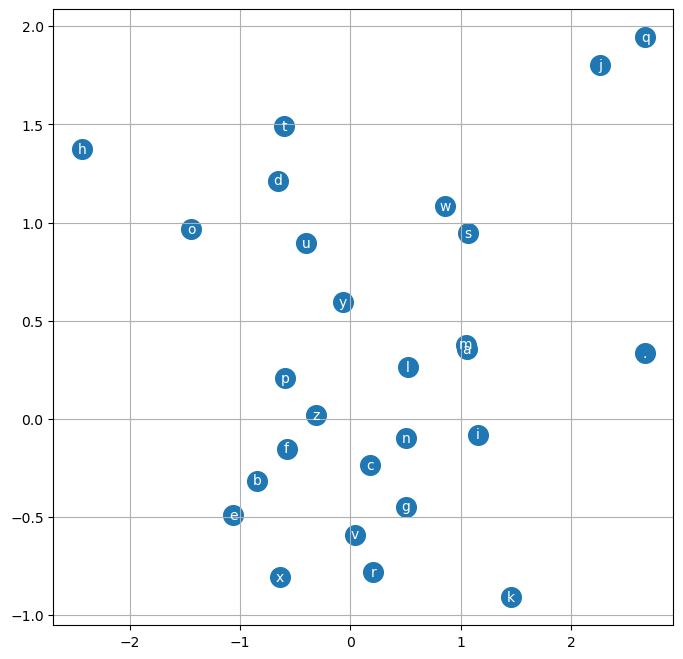

In [75]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [76]:
emb = C[Xdev] # (32, 3, 2)                              # with the orignial model we are underfitting because our 
                                                        # training_loss, dev_loss, test_loss
                                                        # is about the same. our network is not powerful enough to overfit the data.
h = torch.sigmoid(emb.view(-1,60)@ W1 + b1) # (32,100)
j = torch.sigmoid(h @ W2 + b2)
logits = j @ W3 + b3
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1682, grad_fn=<NllLossBackward0>)

In [77]:
emb = C[Xte] # (32, 3, 2)
h = torch.sigmoid(emb.view(-1,60)@ W1 + b1) # (32,100)
j = torch.sigmoid(h @ W2 + b2)
logits = j @ W3 + b3

loss = F.cross_entropy(logits,Yte)
loss

tensor(2.1681, grad_fn=<NllLossBackward0>)

In [78]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * 3
    while True :
        # forward pass the nn
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.sigmoid(emb.view(1,-1) @ W1 + b1)
        j = torch.sigmoid(h @ W2 + b2)
        logits = j @ W3 + b3
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        #shift the context windown and track the samples

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


mohaagmynahiee.
medyn.
alerethruchadrie.
cadeeronelin.
shi.
jenueleighananaraelynn.
hotha.
noshubergahdine.
tricke.
jelionnie.
cas.
brence.
ryy.
julieh.
yuva.
mis.
kyla.
halisa.
yansun.
zakolee.
